
## Including extra features

We are now introducing an additional feature: supplementary information beyond the 
image itself. In this example, we assume we have the object's size or at least an 
estimate of it.

We will simulate the size from a normal distribution. We consider three scenarios
* No overlap between the distributions of the sizes of each class
* Partial between the distributions of the sizes of each class
* High overlap between the distributions of the sizes of each class


In [ ]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader

%cd ..
import modular.samples_setup as cs
from modular import engine
from modular import extra_functions as ef
from modular import model_builder


Let's first simulate some data. We will simulate a data sets with 3500 samples of squares and 
3500 samples of circles. In this case simulate data noise, but if you want you change this.

For the sizes, we follow the three scenarios outlined earlier and consider three different mean values for squares and circles 

In [2]:
# Simulate data (with no noise)
seed = 26
n_samples = [3500] * 2

# Parameters for the extra feature
mu_c = np.array([-2,-1,-0.5,0])
mu_s = np.array([2,1,0.5,0])
sigma_s, sigma_c = 0.5, 0.5
n_scenarios = len(mu_c)

size_c = np.zeros((len(mu_c), n_samples[0]))
size_s = np.zeros((len(mu_c), n_samples[1]))

# Simulate images
data = cs.generate_sample(n=n_samples, noise_prop=1,var=0.2,seed=seed)
images, labels= (data['images'], data['labels'])

# Simulate extra features by scenario
for i in range(n_scenarios):
    np.random.seed(seed)
    size_c[i,] = np.random.normal(mu_c[i], sigma_c, n_samples[0])
    size_s[i,] = np.random.normal(mu_s[i], sigma_s, n_samples[1])

Let's examine how the features vary across the different scenarios

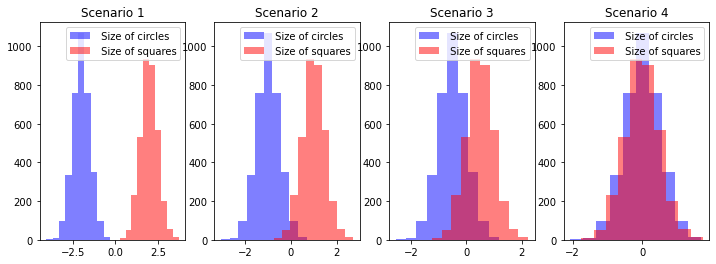

In [3]:
# Plot size for each scenario
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

for i in range(len(mu_c)):
    feature_c = size_c[i,]
    feature_s = size_s[i,]
    axes[i].hist(feature_c, label = f' Size of circles', color = 'blue', alpha = 0.5)
    axes[i].hist(feature_s, label = f' Size of squares', color = 'red', alpha = 0.5)
    axes[i].legend()
    axes[i].set(title=f'Scenario {i+1}')


In the first scenario, we can see that the size alone is sufficient for classification, as there is no overlap. In scenario 2, while there is some overlap, it remains minimal. Scenario 3 represents the case with moderate overlap, and finally Scenario 4 occurs when both sizes have the same distribution, providing no additional information.

In [4]:
# Batch size and epochs
BATCH_SIZE = 50
EPOCHS = 12

# Loss Function
loss_fn = nn.CrossEntropyLoss()

# Split data into train and test sets
n_test = int(sum(n_samples)*0.2)
test_index = np.arange(n_test)
train_index = np.arange(n_test, sum(n_samples))

images_test = images[test_index]
images_train = images[train_index]

label_test = labels[test_index]
label_train = labels[train_index]
    
# keep indices
indx_s = np.where(labels==1)
indx_c = np.where(labels==0)

#### Train and test with no extra Feature

In [ ]:
# Create tensors
X_test = torch.from_numpy(images_test).type(torch.float)
X_train = torch.from_numpy(images_train).type(torch.float)

y_train = torch.from_numpy(label_train).type(torch.long)
y_test = torch.from_numpy(label_test).type(torch.long)

train_dataset = torch.utils.data.TensorDataset(X_train.unsqueeze(1), y_train)
test_dataset = torch.utils.data.TensorDataset(X_test.unsqueeze(1), y_test)

# Create data loader and turn datasets into iterables (batches)
train_dataloader = DataLoader(train_dataset, 
                            batch_size=BATCH_SIZE, 
                            shuffle=False) 

test_dataloader = DataLoader(test_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=False)

# Initialize model and optimizer
model =  model_builder.TVGG(input_shape = 1,  
                            hidden_units= 10, 
                            output_shape = 2)
            
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

# Train test loop
torch.manual_seed(42)
output = engine.train_test_loop(model,train_dataloader,
                                test_dataloader, optimizer, loss_fn,
                                epochs=EPOCHS,print_b=False)

accuracy_test_0  = output['test_acc'][EPOCHS-1] 
ce_test_0  = output['test_ce'][EPOCHS-1] 

print('Test accuracy :',accuracy_test_0)
print('Test Cross-Entropy index is :',ce_test_0)


Test accuracy : 81.85714285714286
Test Cross-Entropy index is : 5.447251490720913


#### Train and test including the Size

In [6]:
# Keep accuracy test
accuracy_test = np.zeros(n_scenarios )
ce_test = np.zeros(n_scenarios)

for i in range(n_scenarios):
    
    # Get extra feature
    feature_c = size_c[i,]
    feature_s = size_s[i,]
    
    extra_feature = np.zeros(len(labels))
    extra_feature[indx_c] = feature_c
    extra_feature[indx_s] = feature_s 
    
    # Repeat each value as a 28x28 matrix to create channel
    ef_arr = np.tile(extra_feature[:, np.newaxis, np.newaxis], (1, 28, 28))
    ef_test = ef_arr[test_index]
    ef_train = ef_arr[train_index]
        
    # Create tensors
    X_test = torch.from_numpy(images_test).type(torch.float)
    X_train = torch.from_numpy(images_train).type(torch.float)

    F_test = torch.from_numpy(ef_test).type(torch.float)
    F_train = torch.from_numpy(ef_train).type(torch.float)

    y_train = torch.from_numpy(label_train).type(torch.long)
    y_test = torch.from_numpy(label_test).type(torch.long)

    # Combine channels 
    XF_train = torch.stack([X_train,F_train], dim=1)
    XF_test = torch.stack([X_test,F_test], dim=1)

    train_dataset = torch.utils.data.TensorDataset(XF_train, y_train)
    test_dataset = torch.utils.data.TensorDataset(XF_test, y_test)
    
    # Create data loader and turn datasets into iterables (batches)
    train_dataloader = DataLoader(train_dataset, 
                                batch_size=BATCH_SIZE, 
                                shuffle=False) 

    test_dataloader = DataLoader(test_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=False)

    # Initialize model and optimizer
    model =  model_builder.TVGG(input_shape = 2, #
                                hidden_units= 10, 
                                output_shape=2)
                
    optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
    
    # Train test loop
    output = engine.train_test_loop(model,train_dataloader,
                                    test_dataloader, optimizer, loss_fn,
                                    epochs=EPOCHS,print_b=False)

    accuracy_test[i]  = output['test_acc'][EPOCHS-1] 
    ce_test[i]  = output['test_ce'][EPOCHS-1] 
    

Let's check the results

In [7]:
print('Test accuracy:',accuracy_test)
print('Test Cross-Entropy:',ce_test)

Test accuracy: [100.          98.14285714  88.07142857  81.        ]
Test Cross-Entropy: [0.         0.7329555  4.71486317 6.74840706]


We achieved perfect performance in Scenario 1, which is expected since the size
distributions do not overlap. Performance improves in Scenario 2 and 3, while in 
Scenario 4 the results are comparable to the case without additional feature.
Lets plot the results!


[]

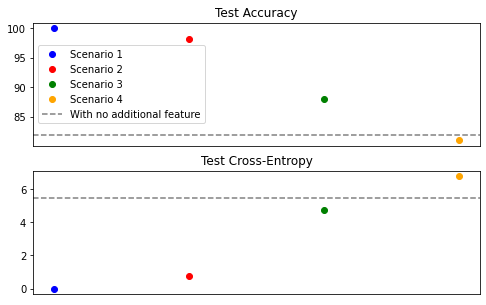

In [8]:
colors = np.array(['blue','red','green','orange'])
x_offsets = [-0.1, 0.0, 0.1, 0.2]  # Offsets for each plot on the x-axis

fig, axes = plt.subplots(2, figsize=(8, 5))

for i in range(n_scenarios):
    axes[0].plot(x_offsets[i],accuracy_test[i],
                'o',
                color= colors[i],
                label=f'Scenario {i+1}'
            )
    axes[1].plot(x_offsets[i],ce_test[i],
                'o',
                color= colors[i],
                label=f'Scenario {i+1}'
            )
axes[0].axhline(y = accuracy_test_0, color = 'grey', linestyle = 'dashed',
                    label = 'With no additional feature')    
axes[0].legend()
axes[0].set(title='Test Accuracy')
axes[0].set_xticks([])  

axes[1].axhline(y = ce_test_0, color = 'grey', linestyle = 'dashed',
                    label = 'With no additional feature')    
axes[1].set(title='Test Cross-Entropy')
axes[1].set_xticks([])  